In [20]:
import pandas as pd
import numpy as np
import math

Implement tanh neuron from basic ops

In [21]:
class Value:

    def __init__(self, data, _children=(), _op='', label='', ):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = Value(other) if not isinstance(other, Value) else other
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other

    
    def __mul__(self, other):
        other = Value(other) if not isinstance(other, Value) else other
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __rmul__(self, other):
        return self * other

    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1- t**2) * out.grad
        out._backward = _backward

        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out
        
    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [22]:
from graphviz import Digraph

def trace(root):
    "build a set of all nodes and edges in a graph"
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) #LR is left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        
        #for any value in the graph, create a rectangular ('record') node

        dot.node(name = uid, label = "%s | data %.4f | grad %.4f" %(n.label, n.data, n.grad), shape ='record')
        if n._op:
            #if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            #connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        #connect n1 to op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
                 
    return dot

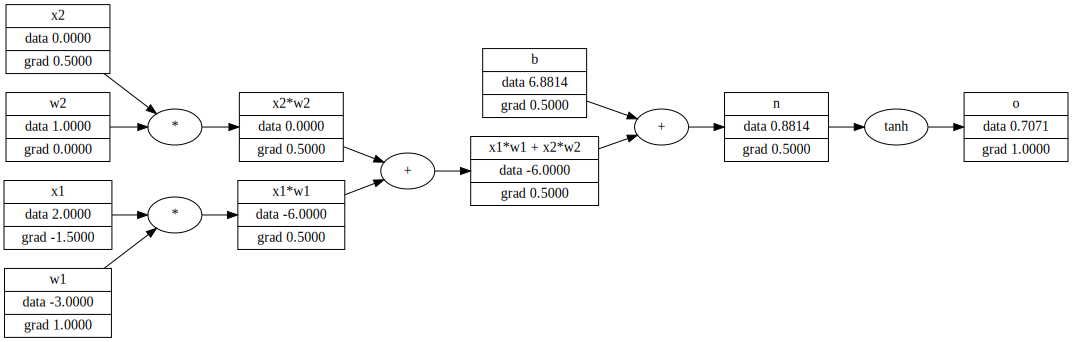

In [23]:
#inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

#bias
b = Value(6.88137358, label='b')

#output
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

o.backward()
draw_dot(o)

In [24]:
o.grad

1.0

In [25]:
x1.grad

-1.5000000148906993

#### Implement division

a/b = a * b^-1

So impl x**k

In [26]:
class Value:

    def __init__(self, data, _children=(), _op='', label='', ):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = Value(other) if not isinstance(other, Value) else other
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other

    
    def __mul__(self, other):
        other = Value(other) if not isinstance(other, Value) else other
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other ** -1
    
    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1- t**2) * out.grad
        out._backward = _backward

        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float))
        x = self.data
        out = Value(x**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other*(x**(other-1)) * out.grad
        out._backward = _backward

        return out
        
    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

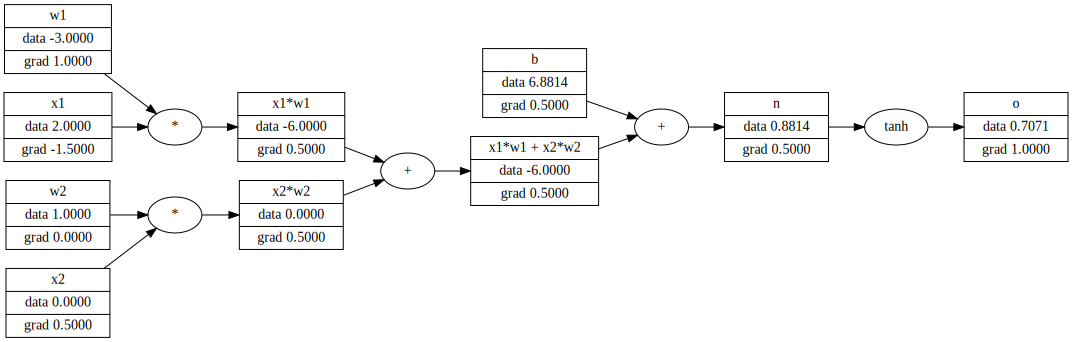

In [27]:
#inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

#bias
b = Value(6.88137358, label='b')

#output
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

o.backward()
draw_dot(o)

In [28]:
w2/w1

Value(data=-0.3333333333333333)

#### Implement substraction

In [29]:
x1 - x2

Value(data=2.0)

Breakdown tanh

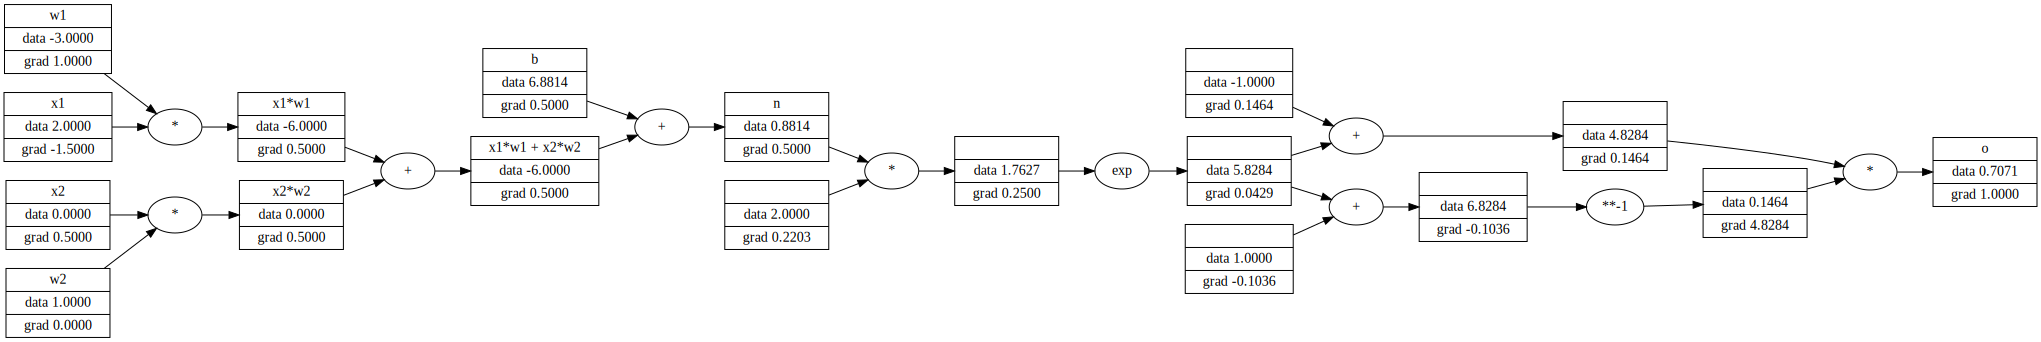

In [30]:
#inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

#bias
b = Value(6.88137358, label='b')

#output
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp()
o = (e - 1)/(e + 1); o.label = 'o'

o.backward()
draw_dot(o)

In [31]:
o

Value(data=0.7071067776767761)

In [32]:
x1.grad

-1.5000000148906993

In [33]:
o._prev

{Value(data=0.146446611161612), Value(data=4.828427042920401)}

In [34]:
o._prev

{Value(data=0.146446611161612), Value(data=4.828427042920401)}

In [35]:
e

Value(data=5.828427042920401)

In [36]:
e._prev

{Value(data=1.76274716)}

In Pytorch

In [37]:
import torch

In [39]:
#inputs
x1 = torch.tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.tensor([0.0]).double(); x2.requires_grad = True

#weights
w1 = torch.tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.tensor([1.0]).double(); w2.requires_grad = True

#bias
b = torch.tensor([6.88137358]).double(); b.requires_grad = True

#output
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())

o.backward()

0.7071066904050358


In [40]:
x1.grad.item(), x2.grad.item(), w1.grad.item(), w2.grad.item()

(-1.5000003851533106, 0.5000001283844369, 1.0000002567688737, 0.0)